In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
# from fancyimpute import KNN
from scipy.stats import chi2_contingency
import seaborn as sns
from random import randrange, uniform
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

In [113]:
from sklearn.metrics import r2_score

In [4]:
os.chdir("F:/backup F ddrive/anushka")

In [158]:
#Load data
cabfare= pd.read_csv("F:/train_cab.csv")

In [6]:
cabfare.shape

(16067, 7)

In [85]:
cabfare.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [159]:
# Convert the fare amount field from an object to a float\n",
cabfare['fare_amount'] = pd.to_numeric(cabfare['fare_amount'], errors='coerce')
cabfare['pickup_datetime']=pd.to_datetime(cabfare['pickup_datetime'],errors='coerce')

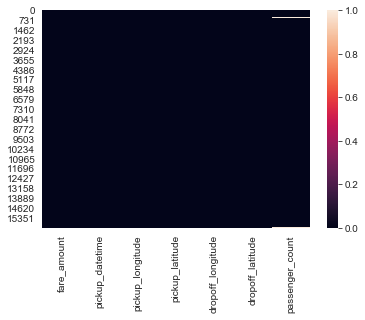

In [84]:
sns.heatmap(cabfare.isnull(), cbar=True)

In [ ]:
#Data Pre processing 
#Outlier Analysis

In [160]:
#dropping observations from fare Amount with negatives values and 0 values
cabfare = cabfare.drop(cabfare[cabfare.fare_amount == 0 ].index)
cabfare = cabfare.drop(cabfare[cabfare.fare_amount < 0].index)

In [87]:
#to view all null values
cabfare.isnull().sum().sort_values(ascending=False)

passenger_count      55
fare_amount          25
pickup_datetime       1
dropoff_latitude      0
dropoff_longitude     0
pickup_latitude       0
pickup_longitude      0
dtype: int64

In [161]:
#for dropping all null values
cabfare=cabfare.drop(cabfare[cabfare.isnull().any(1)].index,axis=0)

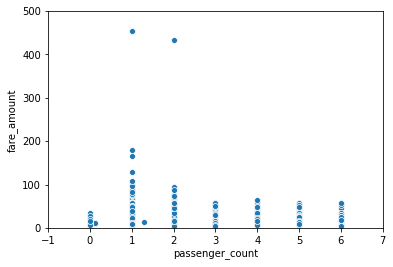

In [12]:
ax = sns.scatterplot(x="passenger_count", y="fare_amount", data=cabfare)
ax.set(xlim=(-1, 7))
ax.set(ylim=(-1,500))
plt.show()

In [13]:
def haversine_np(lon1, lat1, lon2, lat2):
   
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [162]:
cabfare['distance']= haversine_np(cabfare.pickup_longitude,cabfare.pickup_latitude,cabfare.dropoff_longitude,cabfare.dropoff_latitude)

In [163]:
#droping longitude and Latitude columns
cabfare = cabfare.drop(['pickup_longitude'], axis=1)
cabfare = cabfare.drop(['dropoff_longitude'], axis=1)
cabfare = cabfare.drop(['pickup_latitude'], axis=1)
cabfare = cabfare.drop(['dropoff_latitude'], axis=1)

In [92]:
cabfare.describe()

,fare_amount,passenger_count,distance
count,15982.000000,15982.000000,15982.000000
mean,15.034740,2.623490,16.085072
std,431.267821,60.899755,325.461080
min,0.010000,0.000000,0.000000
25%,6.000000,1.000000,1.214059
50%,8.500000,1.000000,2.124320
75%,12.500000,2.000000,3.844832
max,54343.000000,5345.000000,8662.100231


In [80]:
#function for printing all variables for outlier analysis
def plot_feature_outlier(df1, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,3,figsize=(14,14))
    
    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.boxplot(df1[feature])
        plt.xlabel(feature, fontsize=9)
    plt.show()

<Figure size 432x288 with 0 Axes>

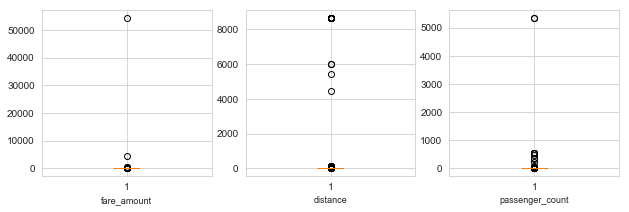

In [93]:
feature =  ["fare_amount","distance","passenger_count"]
plot_feature_outlier(cabfare[:], feature)

In [164]:
feature =  ["fare_amount","distance","passenger_count"]
for i in feature:
    print(i)
    q75, q25 = np.percentile(cabfare.loc[:,i], [75 ,25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    cabfare = cabfare.drop(cabfare[cabfare.loc[:,i] < minimum].index)
    cabfare = cabfare.drop(cabfare[cabfare.loc[:,i] > maximum].index)    

fare_amount
distance
passenger_count


In [95]:
cabfare.describe()

,fare_amount,passenger_count,distance
count,12439.000000,12439.000000,12439.000000
mean,8.491166,1.248768,2.208883
std,3.691159,0.538446,1.446046
min,0.010000,0.000000,0.000000
25%,5.700000,1.000000,1.132812
50%,7.700000,1.000000,1.872510
75%,10.500000,1.000000,3.022111
max,22.100000,3.000000,6.409458


In [99]:
cabfare = cabfare.drop(cabfare[cabfare.passenger_count < 1].index)

In [100]:
cabfare.passenger_count = [int(round(n, 0)) for n in cabfare.passenger_count]

In [101]:
cabfare['passenger_count'].replace({1: 'low', 2: 'med', 3: 'high'}, inplace= True)

In [102]:
#Anova test
results = ols('fare_amount ~ C(passenger_count)', data=cabfare).fit()
anov_table = sm.stats.anova_lm(results, typ=2)
print(anov_table)

                           sum_sq       df         F    PR(>F)
C(passenger_count)      54.094353      2.0  1.983764  0.137594
Residual            168846.825993  12384.0       NaN       NaN


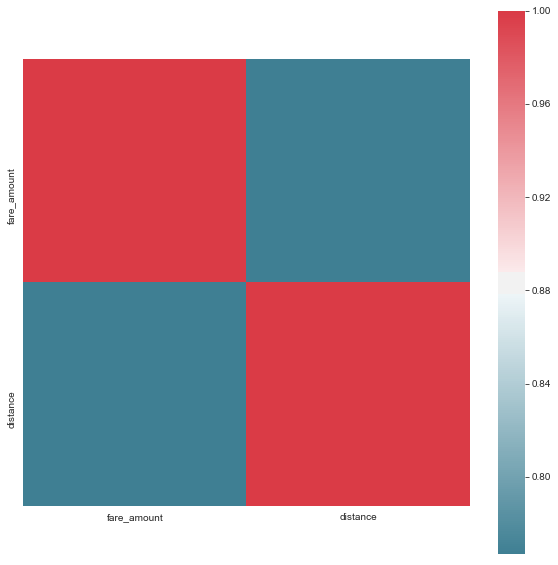

In [98]:
feature =  ["fare_amount","distance"]
df_corr = cabfare.loc[:,feature]
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(10, 10))
#Generate correlation matrix
corr = df_corr.corr()
#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

In [25]:
cabfare.passenger_count.unique()

array([1, 2, 3], dtype=int64)

In [104]:
#function for printing all variables for normalization analysis\n",
def plot_displot(df1,features):
    q = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(15,15))
    for feature in features:
        q += 1
        plt.subplot(2,2,q)
        sns.distplot(df1[feature])
        plt.xlabel(feature, fontsize=9)
    plt.show(); 

<Figure size 432x288 with 0 Axes>

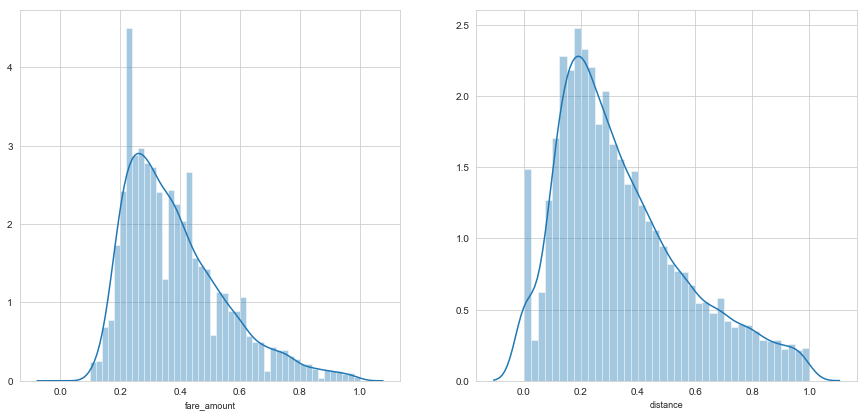

In [107]:
#Normality check
cnames = ["fare_amount","distance"]
plot_displot(cabfare.iloc[:],cnames)
#sns.hist(cabfare['pickup_latitude'], bins=100)"

In [78]:
cabfare.shape

(11688, 5)

In [165]:
#Nomalisation
cnames = ["fare_amount","distance"]
for i in cnames:
    print(i)
    cabfare[i] = (cabfare[i] - min(cabfare[i]))/(max(cabfare[i]) - min(cabfare[i]))

fare_amount
distance


In [166]:
#cabfare = cabfare.drop(['passenger_count'], axis=1)
cabfare = cabfare.drop(['pickup_datetime'], axis = 1)

In [170]:
cabfare.iloc[:,0:1]

,fare_amount
0,0.203259
2,0.257583
3,0.348121
4,0.239475
5,0.547306
6,0.339067
7,0.746492
9,0.402445
10,0.239475
11,0.248529


In [171]:
X = cabfare.iloc[:, [1, 2]]
y = cabfare.iloc[:, 0:1]


In [173]:
from sklearn.svm import SVR

In [175]:
from sklearn.model_selection import KFold

In [178]:
#model Dovelopment
#Divide data into train and test
scores = []
best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))

Train Index:  [ 1244  1245  1246 ... 12436 12437 12438] 

Test Index:  [   0    1    2 ... 1241 1242 1243]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [1244 1245 1246 ... 2485 2486 2487]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [2488 2489 2490 ... 3729 3730 3731]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [3732 3733 3734 ... 4973 4974 4975]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [4976 4977 4978 ... 6217 6218 6219]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [6220 6221 6222 ... 7461 7462 7463]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [7464 7465 7466 ... 8705 8706 8707]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [8708 8709 8710 ... 9949 9950 9951]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 12436 12437 12438] 

Test Index:  [ 9952  9953  9954 ... 11193 11194 11195]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train Index:  [    0     1     2 ... 11193 11194 11195] 

Test Index:  [11196 11197 11198 ... 12436 12437 12438]


C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anushka\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
#model Dovelopment
# #Divide data into train and test
# from sklearn.model_selection import train_test_split
# X=cabfare.iloc[:,1:2]
# y=cabfare.fare_amount
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=123)

In [60]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [62]:
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

In [179]:
#Base Line Modelling
avg_fare=round(np.mean(y_train),2) #11.31
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))*100

print("Basline RMSE of Validation data :",baseline_rmse)
print("Basline R2 of Validation data :",r2)

Basline RMSE of Validation data : 16.14473248969937
Basline R2 of Validation data : -0.002207098954094988


In [180]:
#Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=10, splitter='random').fit(X_train, y_train)

In [181]:
#Apply model on test data
predictions_DT = fit_DT.predict(X_test)

In [182]:
rmse=np.sqrt(mean_squared_error(predictions_DT, y_test))
rmse

0.100645314857583

In [183]:
r2_score(y_test, predictions_DT)

0.611351527794276

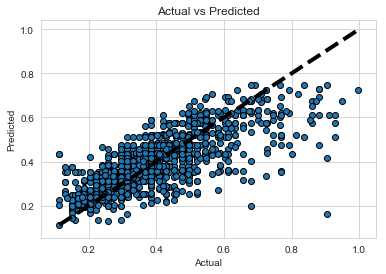

In [184]:
#visualization
fig, ax = plt.subplots()
ax.scatter(y_test,predictions_DT, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [69]:
# linear Regression
from sklearn import linear_model
#Train the model using the training sets 
model = linear_model.LinearRegression()

In [185]:
# Print out the statistics
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [186]:
#make the predictions by the model 
predictions_LR = model.predict(X_test)

In [187]:
r2_score(y_test, predictions_LR)

0.6081649969098879

In [195]:
#Calculate MAPE\n",
#MAPE(y_test, predictions_LR)\n",
lm_rmse=np.sqrt(mean_squared_error(predictions_LR, y_test))
lm_train_rmse=np.sqrt(mean_squared_error(model.predict(X_train), y_train))
print("Test RMSE for Linear Regression is ",lm_rmse)
print("Train RMSE for Linear Regression is ",lm_train_rmse)

Test RMSE for Linear Regression is  0.10105706832337893
Train RMSE for Linear Regression is  0.10789420674939422


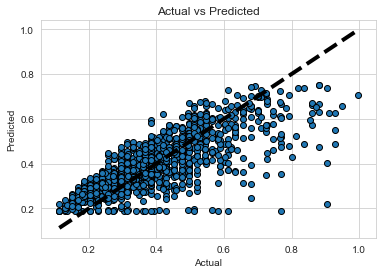

In [189]:
#visualization\n",
fig, ax = plt.subplots()
ax.scatter(y_test,predictions_LR, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [190]:
#RAndom Forest
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

C:\Users\anushka\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RMSE for Random Forest is  0.11541677501982571


In [191]:
r2_score(y_test, rf_pred)

0.4888978483462617

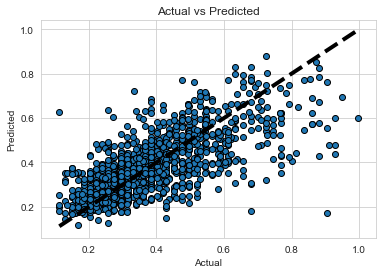

In [192]:
fig,ax = plt.subplots()
ax.scatter(y_test, rf_pred,edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [132]:
#Load data
cab_test= pd.read_csv("F:/test.csv")

In [134]:
cab_test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [135]:
cab_test['pickup_datetime']=pd.to_datetime(cab_test['pickup_datetime'],errors='coerce')

In [137]:
cab_test.isnull().sum().sort_values(ascending=False) 

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
dtype: int64

In [138]:
cab_test['distance']= haversine_np(cabfare.pickup_longitude,cabfare.pickup_latitude,cabfare.dropoff_longitude,cabfare.dropoff_latitude)

In [140]:
#droping longitude and Latitude columns
cab_test = cab_test.drop(['pickup_longitude'], axis=1)
cab_test = cab_test.drop(['dropoff_longitude'], axis=1)
cab_test = cab_test.drop(['pickup_latitude'], axis=1)
cab_test = cab_test.drop(['dropoff_latitude'], axis=1)

In [141]:
#outlier analysis

,pickup_datetime,passenger_count,distance
0,2015-01-27 13:08:24+00:00,1,2.321801
1,2015-01-27 13:08:24+00:00,1,2.423830
2,2011-10-08 11:53:44+00:00,1,0.618239
3,2012-12-01 21:12:12+00:00,1,1.959801
4,2012-12-01 21:12:12+00:00,1,5.383919
5,2012-12-01 21:12:12+00:00,1,3.220526
6,2011-10-06 12:10:20+00:00,1,0.929018
7,2011-10-06 12:10:20+00:00,1,21.526578
8,2011-10-06 12:10:20+00:00,1,3.871529
9,2014-02-18 15:22:20+00:00,1,1.099103


In [143]:
feature =  ["distance","passenger_count"]
for i in feature:
    q75, q25 = np.percentile(cab_test.loc[:,i], [75 ,25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    cab_test = cab_test.drop(cab_test[cab_test.loc[:,i] < minimum].index)
    cab_test = cab_test.drop(cab_test[cab_test.loc[:,i] > maximum].index)    

In [152]:
cnames = ["distance"]
for i in cnames:
    print(i)
    cab_test[i] = (cab_test[i] - min(cab_test[i]))/(max(cab_test[i]) - min(cab_test[i]))

distance


In [144]:
cab_test = cab_test.drop(['passenger_count'], axis=1)

In [148]:
cab_test = cab_test.drop(['pickup_datetime'], axis = 1)

In [153]:
predictions_LR = model.predict(cab_test)

In [193]:
result = pd.DataFrame(predictions_LR)

In [196]:
df = result.to_csv( "result.csv",index = False)

,0
0,0.413962
1,0.372534
2,0.359182
3,0.588216
4,0.241181
5,0.336029
6,0.536398
7,0.294652
8,0.416449
9,0.364064
